In [1]:
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

### 1. Загружаем данные и делаем предобработку:
- *выбираем данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших).*
- *для упрощения обработки можно заменить в столбце new_cases все нули на единицы.*

In [2]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=[2])
data = data[data.location=='Russia']
data = data[data.date >= datetime.datetime(2020, 3, 3)]
data.loc[data.new_cases==0, 'new_cases'] = 1
data.index = data.date
data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,,
2020-03-03,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-05,RUS,Russia,2020-03-05,4,1,0,0,0.027,0.000,0.0,0.0,46414.0,NaN,0.318,NaN,tests performed
2020-03-06,RUS,Russia,2020-03-06,4,1,0,0,0.027,0.000,0.0,0.0,51366.0,4952.0,0.352,0.034,tests performed
2020-03-07,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,0.0,55688.0,4322.0,0.382,0.030,tests performed


- *Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).*

In [3]:
train_size = 50
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

### 2. Постройте графики целевых переменных. 

*Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально.*

<font color='blue'>Действительно видим, что графики похожи на экспоненты</font>

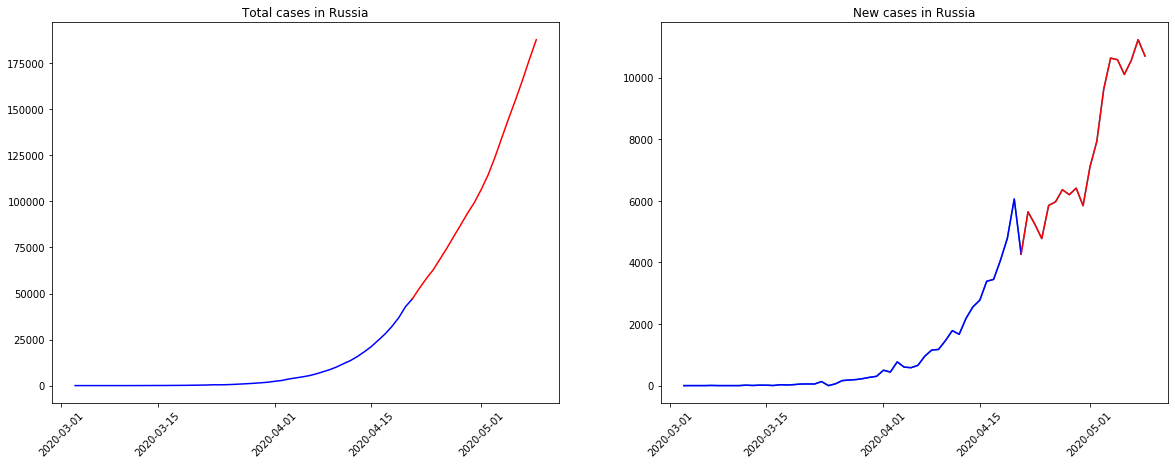

In [4]:
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(data.iloc[:train_size].total_cases, color='blue')
plt.plot(data.iloc[train_size - 1:].total_cases, color='red')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(data.new_cases)
plt.plot(data.iloc[:train_size].new_cases, color='blue')
plt.plot(data.iloc[train_size - 1:].new_cases, color='red')
plt.title('New cases in Russia')
plt.xticks(rotation=45)
plt.show()

#### a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [5]:
from sklearn import linear_model

# Первые 50 дней с 1 по 50 - train
x_train = np.arange(1, train_size + 1)
# y1 - обозначим total cases, y2 - new cases

# Обучаем модели для log(y) = w_0 + w_1*x
log_y1_train = np.log(train_data.total_cases.values)
first_y1_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], log_y1_train)

log_y2_train = np.log(train_data.new_cases.values)
first_y2_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], log_y2_train)

In [6]:
# Предсказания моделей:
x_test = np.arange(x_train[-1], x_train[-1] + len(test_data)) + 1

y1_train_pred = first_y1_model.predict(x_train[:, np.newaxis])
y1_test_pred = first_y1_model.predict(x_test[:, np.newaxis])

y2_train_pred = first_y2_model.predict(x_train[:, np.newaxis])
y2_test_pred = first_y2_model.predict(x_test[:, np.newaxis])

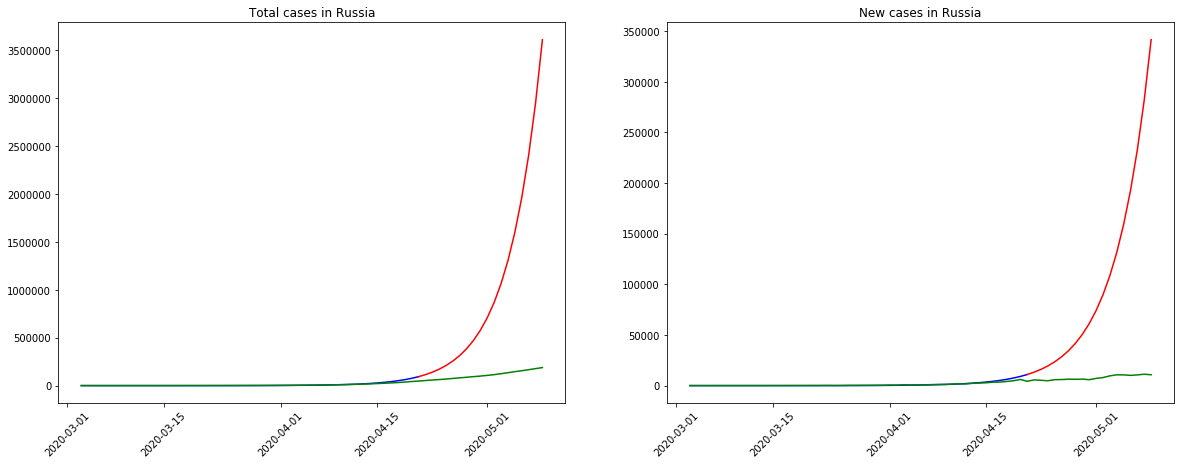

In [7]:
# Вывод графиков
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(data.iloc[:train_size].index, np.exp(y1_train_pred), color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.exp(np.hstack([[y1_train_pred[-1]], y1_test_pred])), color='red')
plt.plot(data.total_cases, color='green')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(data.iloc[:train_size].index, np.exp(y2_train_pred), color='blue')
plt.plot(data.iloc[train_size - 1:].index, np.exp(np.hstack([[y2_train_pred[-1]], y2_test_pred])), color='red')
plt.plot(data.new_cases, color='green')
plt.title('New cases in Russia')
plt.xticks(rotation=45)

plt.show()

### <font color='blue'>Видим, что линейная регрессия для логарифма целевой функции работает мягко говоря не очень хорошо. Проверим, что в логарифмической шкале все выглядит получше:</font>

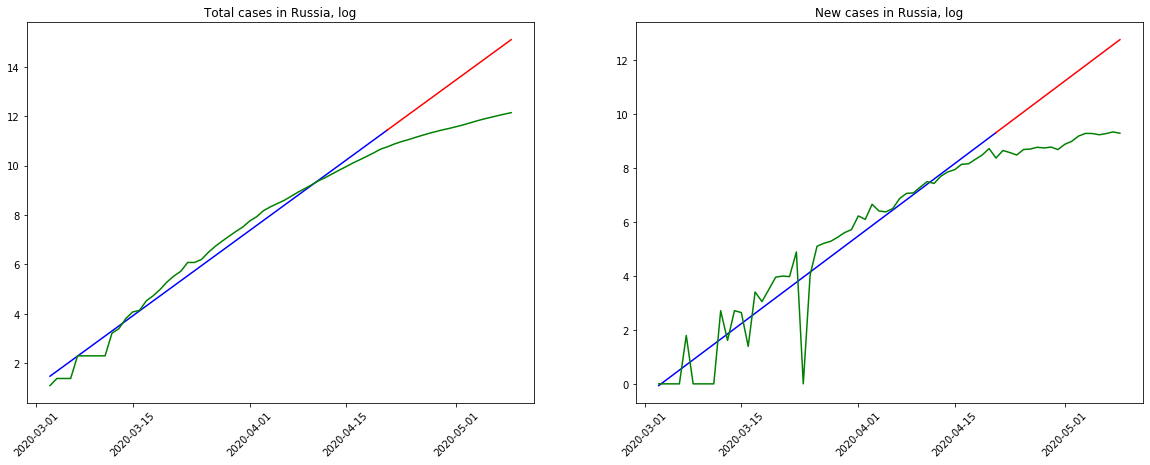

In [8]:
# Вывод графиков
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(data.iloc[:train_size].index, y1_train_pred, color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[y1_train_pred[-1]], y1_test_pred]), color='red')
plt.plot(np.log(data.total_cases), color='green')
plt.title('Total cases in Russia, log')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(data.iloc[:train_size].index, y2_train_pred, color='blue')
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[y2_train_pred[-1]], y2_test_pred]), color='red')
plt.plot(np.log(data.new_cases), color='green')
plt.title('New cases in Russia, log')
plt.xticks(rotation=45)

plt.show()

### <font color='blue'>Видим, что модель действительно обучилась на train части и хорошо (насколько может линейная модель) ее приближает, жалко что нам от этого не легче :-) Также заметим, что данные по new_cases очень шумные и есть несколько дней, в которых не было выявлено новых случаев.</font>

#### b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

#### с) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [9]:
# Функция для вычисления параметров шума - среднего и дисперсии, мы будем применять ее к логарифму целевых переменных

def get_noise_params(y_pred, target):
    errors = y_pred - target
    return np.mean(errors), np.std(errors)

# Параметры шума для total_cases
noise1_mean, noise1_std = get_noise_params(y1_train_pred, log_y1_train)

# Параметры шума для new_cases
noise2_mean, noise2_std = get_noise_params(y2_train_pred, log_y2_train)

print(f'Параметры шума для total_cases: mean = {noise1_mean:0.4f}, std = {noise1_std:0.4f}')
print(f'Параметры шума для new_cases: mean = {noise2_mean:0.4f}, std = {noise2_std:0.4f}')

Параметры шума для total_cases: mean = -0.0000, std = 0.3588
Параметры шума для new_cases: mean = 0.0000, std = 0.8305


### <font color='blue'>Как и ожидалось шум имеет мат ожидание 0 и для total_cases и для new_cases. Подготовим все функции (на основе ноутбука к лекции 2)</font>

In [10]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(-3, 3, N)
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z, min_x=-2, max_x=2, min_y=-2, max_y=2):
    # Make the plot
    plt.axis('equal')
    plt.xlim((min_x, max_x))
    plt.ylim((min_y, max_y))
    X = np.linspace(min_x, max_x, N)
    Y = np.linspace(min_y, max_y, N)
    X, Y = np.meshgrid(X, Y)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.show()
    
def get_likelihood(px, py, noise_mean = 0, noise_std = 0.5):
    return lambda w : np.exp(-0.5 *((w[0] + w[1] * px - py - noise_mean) / (noise_std)) ** 2) / (noise_std * np.sqrt(2.*np.pi))

def bayesian_update(mu, sigma, x, y, noise_std):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (noise_std ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (noise_std ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n
    
def myplot_sample_lines(mu, sigma, n=20, points=None, x_min=-3, x_max=3, y_min=-3, y_max=3):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    xs = np.linspace(x_min, x_max, 100)
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((x_min, x_max))
    plt.xlim((y_min, y_max))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()
    
# Функция для отображения экспонент
def myplot_sample_exponents(mu, sigma, x, y_true = None, n=20, title=None, dates=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    xs = dates if dates is not None else x
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*x), linewidth=.1, color='0.5')
    if y_true is not None:
        plt.plot(xs, y_true, color='red', label='actual')
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

### <font color='blue'>Проверим на одной точке. Априорное распределение взяли нормальным вокруг с центром в (0, 0).</font>

(250, 250)


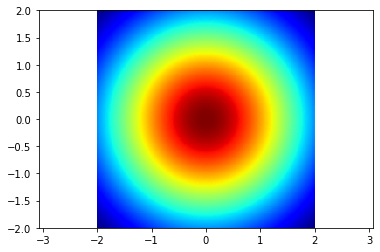

In [11]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

1 1.0986122886681098


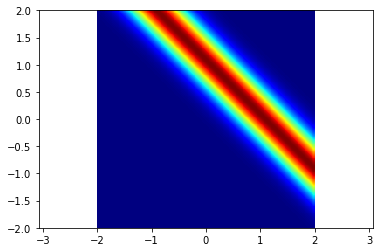

In [12]:
print(x_train[0], log_y1_train[0])
px, py = x_train[0], log_y1_train[0]
cur_likelihood = get_likelihood(px, py, noise_std=noise1_std)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

myplot_heatmap(Z)

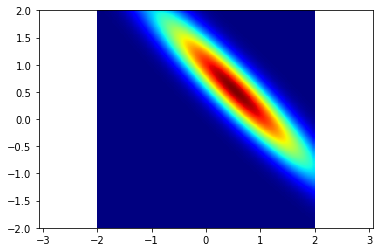

In [13]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std=noise1_std)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

## <font color='blue'>Сделаем вывод для total_cases:</font>

(250, 250)


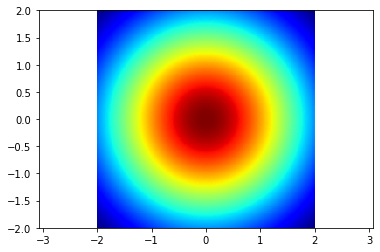

In [14]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

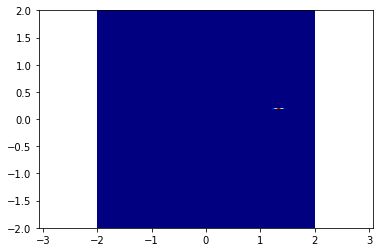

In [15]:
for px, py in zip(x_train, log_y1_train):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std=noise1_std)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

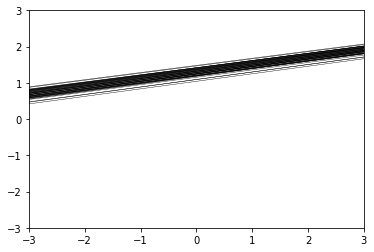

In [16]:
myplot_sample_lines(cur_mu, cur_sigma, n=50)

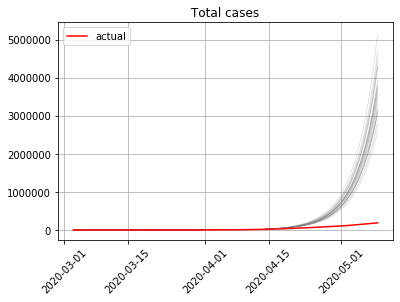

In [17]:
x = np.arange(len(data)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, y_true=data.total_cases.values, n=50,
                        title='Total cases', dates=data.index)

### <font color='blue'>Посмотрим, что наши модели предсказывают на 1 мая, 1 июня и 1 сентября</font>

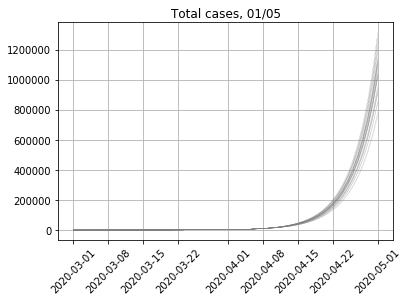

In [18]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(62)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='Total cases, 01/05', dates=dates)

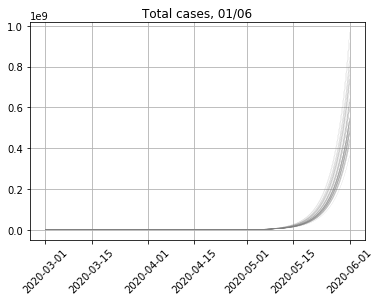

In [19]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(93)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='Total cases, 01/06', dates=dates)

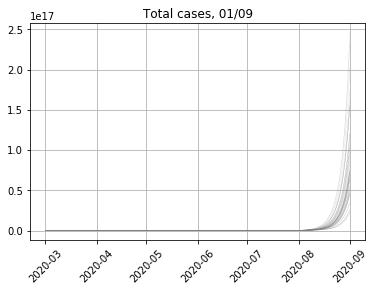

In [20]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(185)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='Total cases, 01/09', dates=dates)

### <font color='blue'>По графикам видим:</font>
    - на 1-е мая предсказания моделей лежат в границах 0.75 - 1.25 млн случаев - очень пессиместичный сценарий, как видим сейчас - в реальности (по крайней мере официальные) числа существенно меньше
    - на 1-е июня предсказание моделей примерно лежат в границах 400 - 800 млрд людей - выглядит нереалистично - на земле живет существенно меньше людей, очевидно, что экспонента очень плохо прогнозирует рост случаев заболевание в будущем.
    - на 1-е сентября прогнозы где-то между 0.5 * 1e+17 и 1.5 * 1e+17

### <font color='blue'>Построим предсказательные распределения, эмпирически, исходя из данных сэмплирования.</font>

In [21]:
may_1st = dates.index(datetime.datetime(2020, 5, 1)) + 1
jun_1st = dates.index(datetime.datetime(2020, 6, 1)) + 1
spt_1st = dates.index(datetime.datetime(2020, 9, 1)) + 1

In [22]:
def sample_predictions(mu, sigma, xs, n):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    result = []
    for w in my_w:
        result.append(np.exp(w[0] + w[1]*xs))
    return np.array(result).transpose()

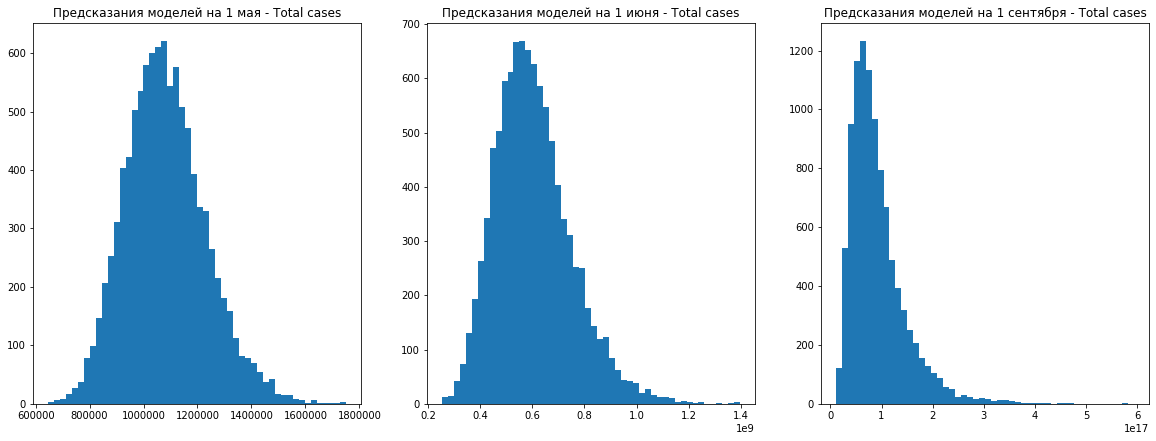

Среднее значение на 1 мая: 1081382
Среднее значение на 1 июня: 604793757
Среднее значение на 1 сентября: 92371012061012656


In [23]:
xs = np.array([may_1st, jun_1st, spt_1st])
preds = sample_predictions(cur_mu, cur_sigma, xs, n=10000)

plt.subplots(1, 3, figsize=(20, 7))
plt.subplot(131)
plt.title('Предсказания моделей на 1 мая - Total cases')
plt.hist(preds[0], bins=50)
plt.subplot(132)
plt.title('Предсказания моделей на 1 июня - Total cases')
plt.hist(preds[1], bins=50)
plt.subplot(133)
plt.title('Предсказания моделей на 1 сентября - Total cases')
plt.hist(preds[2], bins=50)
plt.show()
print(f'Среднее значение на 1 мая: {np.mean(preds[0]):0.0f}')
print(f'Среднее значение на 1 июня: {np.mean(preds[1]):0.0f}')
print(f'Среднее значение на 1 сентября: {np.mean(preds[2]):0.0f}')

### <font color='blue'>Вывод: экпоненциальная модель плохо подходит для прогнозирования ситуации с коронавирусом. Это становится особенно заметно при удалении от train датасета - связано это с тем, что экспоненциальный рост не может быть неограниченным и рано или поздно эпидемя выходит на плато (как максимум - заразится все население планеты). Далее проведем аналогичный анализ для New cases и  потом перейдем к другим моделям.</font>

## <font color='blue'>Сделаем вывод для new_cases:</font>

(250, 250)


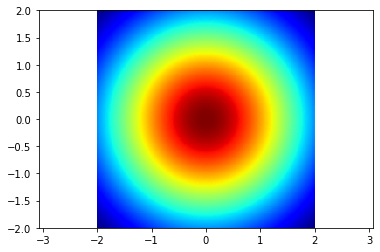

In [24]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

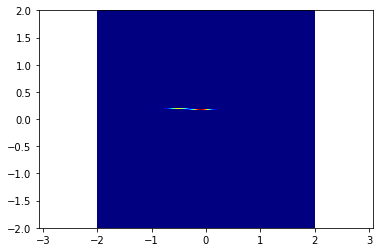

In [25]:
for px, py in zip(x_train, log_y2_train):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std=noise2_std)

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

In [26]:
cur_mu

array([-0.24847811,  0.19091321])

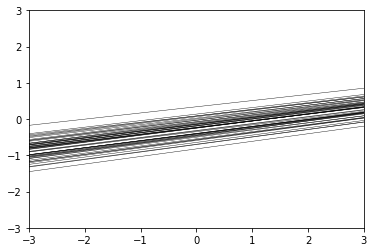

In [27]:
myplot_sample_lines(cur_mu, cur_sigma, n=50)

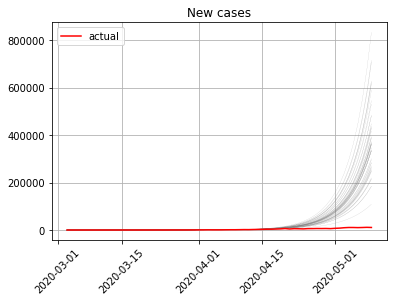

In [28]:
x = np.arange(len(data)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, y_true=data.new_cases.values, n=50,
                        title='New cases', dates=data.index)

### <font color='blue'>Посмотрим, что наши модели предсказывают на 1 мая, 1 июня и 1 сентября</font>

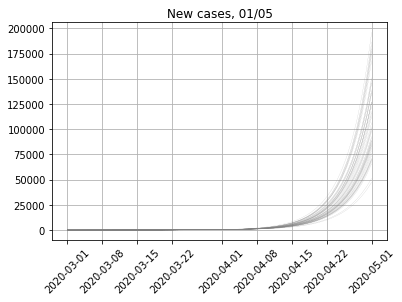

In [29]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(62)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='New cases, 01/05', dates=dates)

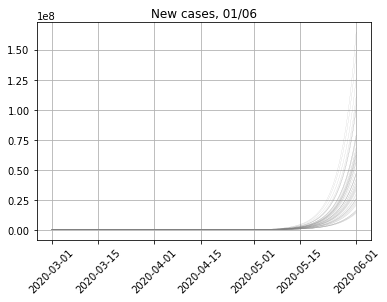

In [30]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(93)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='New cases, 01/06', dates=dates)

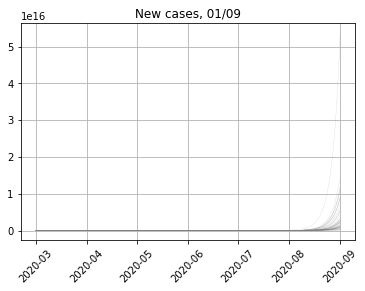

In [31]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(185)]
x = np.arange(len(dates)) + 1
myplot_sample_exponents(cur_mu, cur_sigma, x=x, n=50,
                        title='New cases, 01/09', dates=dates)

### <font color='blue'>По графикам видим:</font>
    - на 1-е мая предсказания моделей лежат в границах 50 - 200 тысяч новых случаев - очень пессиместичный сценарий, как видим сейчас - в реальности (по крайней мере официальные) числа существенно меньше
    - на 1-е июня предсказание моделей примерно лежат в границах 200 - 800 млн людей - выглядит нереалистично - на земле живет существенно меньше людей, очевидно, что экспонента очень плохо прогнозирует рост случаев заболевание в будущем.
    - на 1-е сентября прогнозы сравнимы с 1e+16 - больше чем население Земли

### <font color='blue'>Построим предсказательные распределения, эмпирически, исходя из данных сэмплирования.</font>

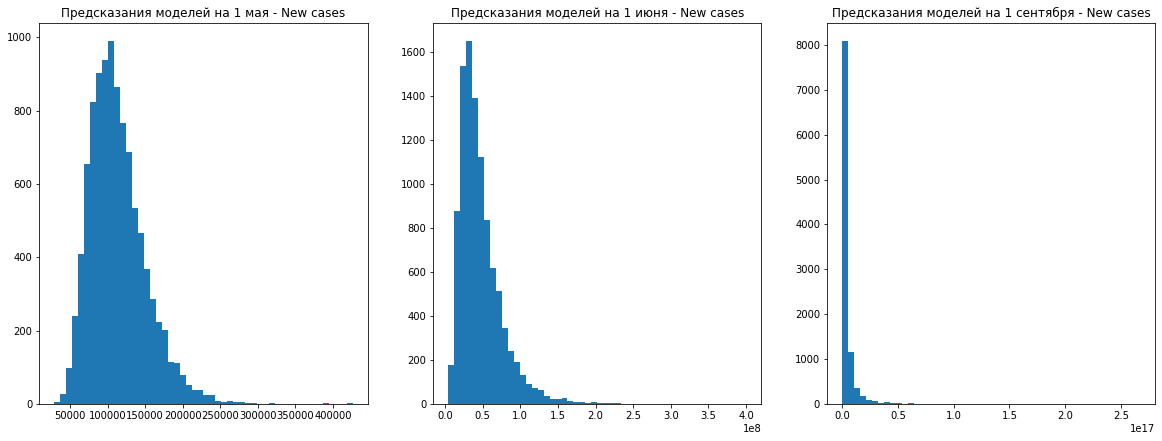

Среднее значение на 1 мая: 113242
Среднее значение на 1 июня: 46758802
Среднее значение на 1 сентября: 3900383004118652


In [32]:
xs = np.array([may_1st, jun_1st, spt_1st])
preds = sample_predictions(cur_mu, cur_sigma, xs, n=10000)

plt.subplots(1, 3, figsize=(20, 7))
plt.subplot(131)
plt.title('Предсказания моделей на 1 мая - New cases')
plt.hist(preds[0], bins=50)
plt.subplot(132)
plt.title('Предсказания моделей на 1 июня - New cases')
plt.hist(preds[1], bins=50)
plt.subplot(133)
plt.title('Предсказания моделей на 1 сентября - New cases')
plt.hist(preds[2], bins=50)
plt.show()
print(f'Среднее значение на 1 мая: {np.mean(preds[0]):0.0f}')
print(f'Среднее значение на 1 июня: {np.mean(preds[1]):0.0f}')
print(f'Среднее значение на 1 сентября: {np.mean(preds[2]):0.0f}')

### <font color='blue'>Вывод аналогичен задаче про Total Cases: экпоненциальная модель плохо подходит для прогнозирования ситуации с коронавирусом. Это становится особенно заметно при удалении от train датасета - связано это с тем, что экспоненциальный рост не может быть неограниченным и рано или поздно эпидемя выходит на плато (как максимум - заразится все население планеты). Далее перейдем к другим моделям.</font>

## 3) Сигмоида
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

In [33]:
from scipy.stats import norm

<font color='blue'>Используем форму сигмоиды:

$\Phi(x) = \frac{1}{\sqrt{2\pi}\sigma}\int_{-\infty}^{x}e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt$

Количество зараженных изменяется не от 0 до 1, а от 0 до $L$, где $L$ - общее число зараженных, поэтому:

$y(x) = \frac{L}{\sqrt{2\pi}\sigma}\int_{-\infty}^{x}e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt$ </font>

### <font color='blue'>Идея номер 1 - используем функцию probit, а общее число зараженных за все время эпидемии - гиперпараметр</font>

<font color='blue'>$L$ в этой ситуации - гиперпараметр, который будем подбирать

$y(x) = \frac{L}{\sqrt{2\pi}\sigma}\int_{-\infty}^{x}e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt$

$\frac{y(x)}{L} = \frac{1}{\sqrt{2\pi}\sigma}\int_{-\infty}^{x}e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt$ (1)

Используем функцию $probit = \phi$:

$\phi(\Phi(x)) = x$

Функция $probit$ есть в библиотеке scipy.stats: norm.ppf

Отметим, что probit можно обобщить для нормального распределения с произвольными $\mu$ и $\sigma$:

$\phi(\alpha;\mu,\sigma) = \mu + \sigma\phi(\alpha)$

Применяем это к (1)Ж

$x = \phi(\frac{y(x)}{L};\mu,\sigma) = \mu + \sigma\phi(\frac{y(x)}{L})$

Итого получили для целевой переменной $z = \phi(\frac{y(x)}{L})$, которую можем для конкретного гиперпараметра $L$ вычислить из $y$, линейную модель 

$z = w_0 + w_1 * x$ - обучим такую модель для $L = 600000$ (для примера)</font>

In [34]:
L = 600000
probit_y1_train = norm.ppf(train_data.total_cases.values/L)
probit_y1_test = norm.ppf(test_data.total_cases.values/L)

def get_sigmoid(L):
    return lambda x: norm.cdf(x) * L

In [35]:
first_probit_y1_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], probit_y1_train)
y1_probit_train_pred = first_probit_y1_model.predict(x_train[:, np.newaxis])
y1_probit_test_pred = first_probit_y1_model.predict(x_test[:, np.newaxis])

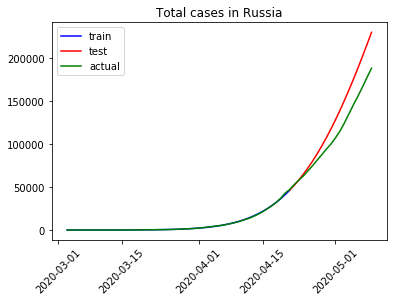

In [36]:
inv_func = get_sigmoid(L)
plt.plot(data.iloc[:train_size].index, inv_func(y1_probit_train_pred),
                                                color='blue',
                                                label='train')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index,
         inv_func(np.hstack([[y1_probit_train_pred[-1]], y1_probit_test_pred])),
         color='red',
         label='test')
plt.plot(data.total_cases, color='green', label='actual')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### <font color='blue'>Видим что уже сильно лучше, чем экспонента, но ведь как-то нужно подбирать L. Используем старый добрый grid search:</font>

Min train loss = 0.0014, L = 850000
Min test loss = 0.0007, L = 375000


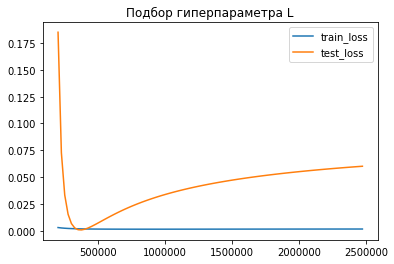

In [37]:
best_train_loss = np.inf
best_train_L = 0
best_test_loss = np.inf
best_test_L = 0
losses = []

Ls = np.arange(200000, 2500000, 25000)
for L in Ls:
    sigmoid = get_sigmoid(L)
    probit_y1_train = norm.ppf(train_data.total_cases.values/L)
    probit_y1_test = norm.ppf(test_data.total_cases.values/L)
    model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], probit_y1_train)
    probit_train_pred = model.predict(x_train[:, np.newaxis])
    probit_test_pred = model.predict(x_test[:, np.newaxis])
    train_loss = np.mean((probit_train_pred - probit_y1_train)**2)
    test_loss = np.mean((probit_test_pred - probit_y1_test)**2)
    losses.append([train_loss, test_loss])
    if train_loss <= best_train_loss:
        best_train_loss = train_loss
        best_train_L = L
    if test_loss <= best_test_loss:
        best_test_loss = test_loss
        best_test_L = L
        
print(f'Min train loss = {best_train_loss:0.4f}, L = {best_train_L}')
print(f'Min test loss = {best_test_loss:0.4f}, L = {best_test_L}')
losses = np.array(losses)
plt.plot(Ls, losses[:, 0], label='train_loss')
plt.plot(Ls, losses[:, 1], label='test_loss')
plt.title('Подбор гиперпараметра L')
plt.legend()
plt.show()

### <font color='blue'>Сравним с train и test</font>

<font color='blue'>Здесь используем $L$, которая дала наименьгий loss на train_data.</font>

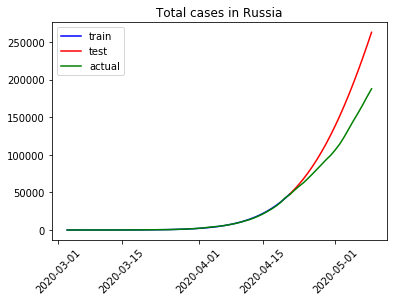

In [38]:
L = best_train_L
sigmoid = get_sigmoid(L)
probit_y1_train = norm.ppf(train_data.total_cases.values/L)
probit_y1_test = norm.ppf(test_data.total_cases.values/L)
model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], probit_y1_train)
probit_train_pred = model.predict(x_train[:, np.newaxis])
probit_test_pred = model.predict(x_test[:, np.newaxis])

inv_func = get_sigmoid(L)
plt.plot(data.iloc[:train_size].index, inv_func(probit_train_pred), color='blue', label = 'train')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index,
         inv_func(np.hstack([[probit_train_pred[-1]], probit_test_pred])),
         color='red',
         label='test')
plt.plot(data.total_cases, color='green', label='actual')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### <font color='blue'>Построим предсказание в будущее</font>

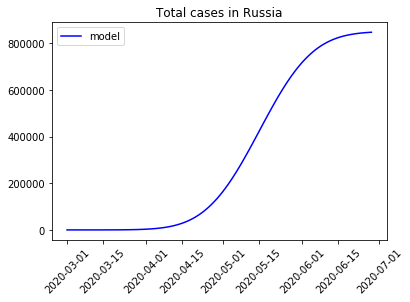

In [39]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(120)]
x = np.arange(len(dates)) + 1
y_future = model.predict(x[:, np.newaxis])
plt.plot(dates, inv_func(y_future), color='blue', label='model')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### <font color='blue'>Байесовский вывод</font>
<font color='blue'>Здесь заметим, что test_data очень сильно отличается от  train_data в части новых случаев в день, поэтому здесь берем $L$, с наилучшим loss на test_data</font>

(250, 250)


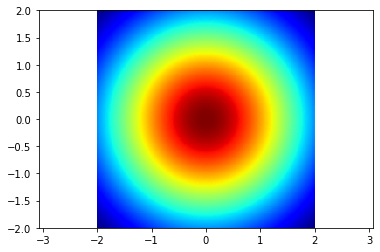

In [40]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
noise_mean, noise_std = get_noise_params(probit_train_pred, probit_y1_train)

X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

In [41]:
L = best_test_L
inv_func = get_sigmoid(L)
probit_y1_train = norm.ppf(train_data.total_cases.values/L)
probit_y1_test = norm.ppf(test_data.total_cases.values/L)

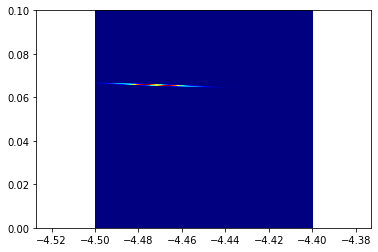

In [42]:
i = len(x_train)
for px, py in zip(x_train[:i], probit_y1_train[:i]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std=noise_std)

min_x= -4.5
max_x= -4.4
min_y = 0
max_y = 0.1

X = np.linspace(min_x, max_x, N)
Y = np.linspace(min_y, max_y, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z, min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)

In [43]:
def myplot_sample_sigmoids(mu, sigma, inv_func, x, y_true = None, n=20, title=None, dates=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    xs = dates if dates is not None else x
    for w in my_w:
        plt.plot(xs, inv_func(w[0] + w[1]*x), linewidth=.1, color='0.5')
    if y_true is not None:
        plt.plot(xs, y_true, color='red', label='actual')
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

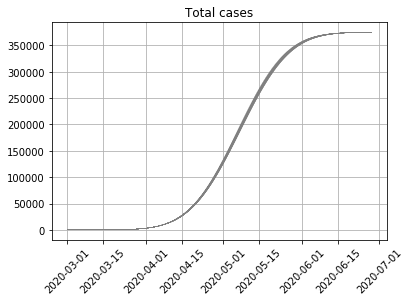

In [44]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(120)]
x = np.arange(len(dates)) + 1
myplot_sample_sigmoids(cur_mu, cur_sigma, inv_func, x=x, n=150,
                       title='Total cases', dates=dates)

### <font color='blue'>Уже больше похоже на что-то разумное, но хочется все-таки полностью подбирать все параметры сигмоды с помощью линейной регрессии. </font>
    
### <font color='blue'>Идея номер 2 - Попробуем через логарифм производной. </font>

<font color='blue'> Вспомним нашу модель:
    
$y(x) = \frac{L}{\sqrt{2\pi}\sigma}\int_{-\infty}^{x}e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt$

Заметим, что по смыслу new_cases это производная от total_cases, "продифференцируем":

$y_{new-cases}(x) = \frac{L}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

Прологарифмируем:

$\log(y_{new-cases}(x)) = \log L - \frac{1}{2}\log(2\pi\sigma^2) - \frac{x^2-2x\mu+\mu^2}{2\sigma^2} = -\frac{1}{2\sigma^2}x^2 + \frac{\mu}{\sigma^2}x + \log L - \frac{1}{2}\log(2\pi\sigma^2) - \frac{\mu^2}{2\sigma^2} = w_0 + w_1 x + w_2 x^2$, где:

$w_0 = \log L - \frac{1}{2}\log(2\pi\sigma^2) - \frac{\mu^2}{2\sigma^2}$

$w_1 = \frac{\mu}{\sigma^2}$

$w_2 = -\frac{1}{2\sigma^2}$

Таким образом мы сможем обучить параметры $w_0, w_1, w_2$ при помощи регрессии, а потом выразить из них параметры исходной модели:

$\sigma = \sqrt{\frac{-1}{2w_2}}$

$\mu = w_1 \sigma^2$

$L = e^{w_0 + \frac{\mu^2}{2\sigma^2}+\frac{1}{2}\log(2\pi\sigma^2)}$

</font>

In [45]:
train_size = 50
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
dy = train_data.new_cases
log_dy = np.log(dy)
x_train = np.arange(1, train_size + 1)
x_train = np.stack([x_train, x_train ** 2]).transpose()

In [46]:
log_dy_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train, log_dy)
x_test = np.arange(x_train[-1, 0], x_train[-1, 0] + len(test_data)) + 1
x_test = np.stack([x_test, x_test ** 2]).transpose()
log_dy_train_pred = log_dy_model.predict(x_train)
log_dy_test_pred = log_dy_model.predict(x_test)

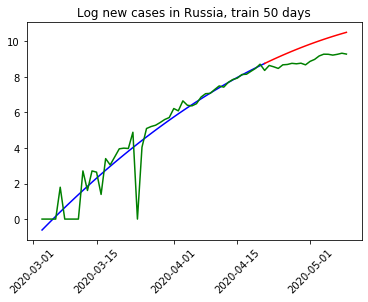

In [47]:
plt.plot(data.iloc[:train_size].index, log_dy_train_pred, color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[log_dy_train_pred[-1]], log_dy_test_pred]), color='red')
plt.plot(np.log(data.new_cases), color='green')
plt.title('Log new cases in Russia, train 50 days')
plt.xticks(rotation=45)
plt.show()

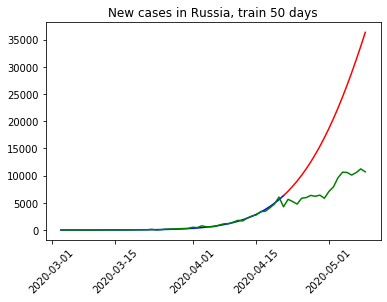

In [48]:
plt.plot(data.iloc[:train_size].index, np.exp(log_dy_train_pred), color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.exp(np.hstack([[log_dy_train_pred[-1]], log_dy_test_pred])), color='red')
plt.plot(data.new_cases, color='green')
plt.title('New cases in Russia, train 50 days')
plt.xticks(rotation=45)
plt.show()

<font color='blue'> Очень хорошо видно, что модель отлично приближает train_data, но затем характер данных меняется и качество предсказаний резко ухудшается. Тут мне пришла в голову идея увеличить размер train_data - далее это будет сделано</font>

In [49]:
train_pred_y = np.cumsum(np.exp(log_dy_train_pred))
test_pred_y = np.cumsum(np.exp(log_dy_test_pred)) + train_pred_y[-1]

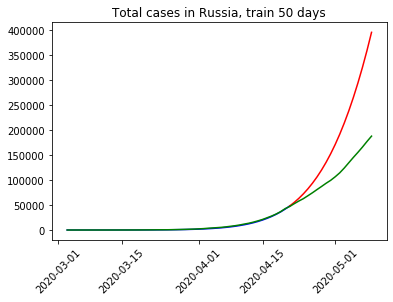

In [50]:
plt.plot(data.iloc[:train_size].index, train_pred_y, color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[train_pred_y[-1]], test_pred_y]), color='red')
plt.plot(data.total_cases, color='green')
plt.title('Total cases in Russia, train 50 days')
plt.xticks(rotation=45)
plt.show()

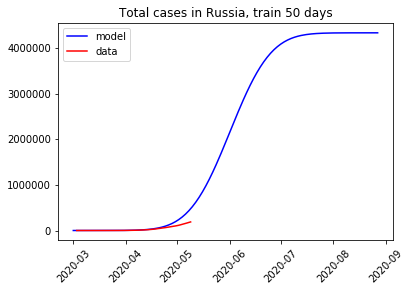

In [51]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(180)]
x = np.arange(len(dates)) + 1
x = np.stack([x, x ** 2]).transpose()
y_future_log = log_dy_model.predict(x)
y_future = np.cumsum(np.exp(y_future_log))
plt.plot(dates, y_future, color='blue', label='model')
plt.plot(data.total_cases, color='red', label='data')
plt.title('Total cases in Russia, train 50 days')
plt.xticks(rotation=45)
plt.legend()
plt.show()

<font color='blue'> Получился тоже весьма пессимистичный прогноз, который уже обгоняет реальные данные.</font>

<font color='blue'> Начиная с этого места я увеличил размер train_data до 60 дней, чтобы модель более соответствовала действительности (так как видим существенное изменение характера кривой количества новых больных в эти 10 дней)</font>

In [52]:
train_size = 60
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
dy = train_data.new_cases
log_dy = np.log(dy)
x_train = np.arange(1, train_size + 1)
x_train = np.stack([x_train, x_train ** 2]).transpose()

In [53]:
log_dy_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train, log_dy)
x_test = np.arange(x_train[-1, 0], x_train[-1, 0] + len(test_data)) + 1
x_test = np.stack([x_test, x_test ** 2]).transpose()
log_dy_train_pred = log_dy_model.predict(x_train)
log_dy_test_pred = log_dy_model.predict(x_test)

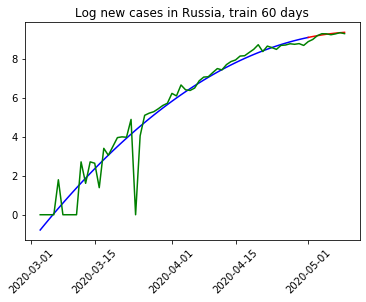

In [54]:
plt.plot(data.iloc[:train_size].index, log_dy_train_pred, color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[log_dy_train_pred[-1]], log_dy_test_pred]), color='red')
plt.plot(np.log(data.new_cases), color='green')
plt.title('Log new cases in Russia, train 60 days')
plt.xticks(rotation=45)
plt.show()

<font color='blue'> Парабола хорошо приближает логарифм новых случаев</font>

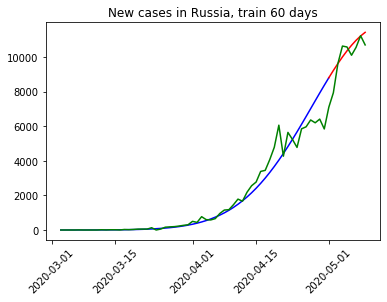

In [55]:
plt.plot(data.iloc[:train_size].index, np.exp(log_dy_train_pred), color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.exp(np.hstack([[log_dy_train_pred[-1]], log_dy_test_pred])), color='red')
plt.plot(data.new_cases, color='green')
plt.title('New cases in Russia, train 60 days')
plt.xticks(rotation=45)
plt.show()

<font color='blue'> Новые случаи в день выглядят неплохо</font>

In [56]:
train_pred_y = np.cumsum(np.exp(log_dy_train_pred))
test_pred_y = np.cumsum(np.exp(log_dy_test_pred)) + train_pred_y[-1]

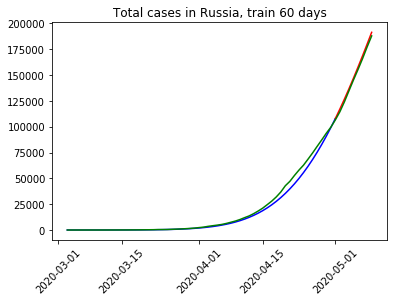

In [57]:
plt.plot(data.iloc[:train_size].index, train_pred_y, color='blue')
# np.stack исключительно для того, чтобы на графике не было пропуска
plt.plot(data.iloc[train_size - 1:].index, np.hstack([[train_pred_y[-1]], test_pred_y]), color='red')
plt.plot(data.total_cases, color='green')
plt.title('Total cases in Russia, train 60 days')
plt.xticks(rotation=45)
plt.show()

<font color='blue'>Модель хорошо приближает и train и test</font>

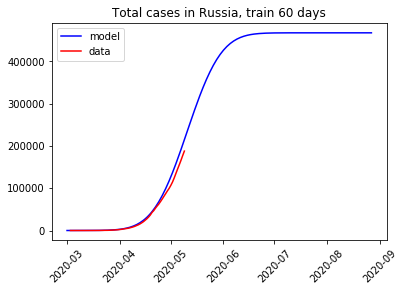

In [58]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(180)]
x = np.arange(len(dates)) + 1
x = np.stack([x, x ** 2]).transpose()
y_future_log = log_dy_model.predict(x)
y_future = np.cumsum(np.exp(y_future_log))
plt.plot(dates, y_future, color='blue', label='model')
plt.plot(data.total_cases, color='red', label='data')
plt.title('Total cases in Russia, train 60 days')
plt.xticks(rotation=45)
plt.legend()
plt.show()

<font color='blue'>На вид очень неплохое предсказание - конкретная сигмоида очень неплохо приближает имеющиеся данные.</font>

#### b) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

### Баесовский вывод

In [59]:
def bayesian_update(mu, sigma, x, y, noise_std):
    x_matrix = np.array([[1, *x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (noise_std ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (noise_std ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [60]:
def myplot_sample_bayesian_sigmoids(mu, sigma, x, y_true = None, n=20, title=None, dates=None, ylim=2e6):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    xs = dates if dates is not None else x
    for w in my_w:
        y = np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2))
        plt.plot(xs, y, linewidth=.1, color='0.5')
    if y_true is not None:
        plt.plot(xs, y_true, color='red', label='actual')
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim((0, ylim))
    plt.grid()
    plt.show()

<font color='blue'>Я попробовал обучить модель на всем train датасете, но дисперсия апостериорного распределения вышла слишком большой, я попытался найти причину такого поведения и обнаружил, что это связано с тем, что среди первых дней было несколько, в которых были 0 в графе new_cases, это приводило к тому, что распределение прямых приближающих логарифм new_cases была большая дисперсия. Вылечилось это тем, что я беру теперь данные, начиная с 25 дня:</font>

In [61]:
start_day = 25
log_dy_model = linear_model.LinearRegression(fit_intercept=True).fit(x_train[start_day:], log_dy[start_day:])
log_dy_train_pred = log_dy_model.predict(x_train[start_day:])

In [62]:
log_noise_mean, log_noise_std = get_noise_params(log_dy_train_pred, log_dy[start_day:])
cur_mu, cur_sigma = np.array([-1, -1, -1]), 2*np.array([[10, 0, 0], [0, 10, 0], [0, 0, 10]])

i = len(x_train)
for px, py in zip(x_train[:i], log_dy[:i]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, noise_std=log_noise_std)

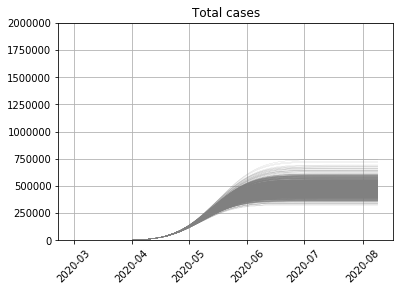

In [63]:
start = datetime.datetime(year=2020, month=3, day=1)
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(cur_mu, cur_sigma, x=x, n=1500,
                                title='Total cases', dates=dates)

#### c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [64]:
def get_sigmoid_parameters(w):
    sigma = np.sqrt(-1/(2*w[2]))
    mu = w[1] * sigma ** 2
    L = np.exp(w[0] + (mu**2)/(2*sigma**2)+0.5*np.log(2*np.pi*sigma**2))
    return {'L': L, 'mu': mu, 'sigma': sigma}

In [65]:
get_sigmoid_parameters(cur_mu)

{'L': 467626.2012708591, 'mu': 72.12427344392817, 'sigma': 15.778065316643625}

In [66]:
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 1500)
total_cases = []
for w in my_w:
    params = get_sigmoid_parameters(w)
    total_cases.append(params['L'])
total_cases = np.array(total_cases)

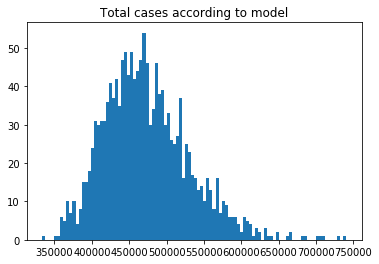

10-й процентиль: 405647
90-й процентиль: 549632


In [67]:
plt.title('Total cases according to model')
plt.hist(total_cases, bins=100)
plt.show()
print(f'10-й процентиль: {np.percentile(total_cases, 10):0.0f}')
print(f'90-й процентиль: {np.percentile(total_cases, 90):0.0f}')

### 4. Бонус: 
проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [68]:
def plot_country_data(data): 
    location = data.iloc[0].location
    plt.subplots(1, 2, figsize=(20, 7))

    plt.subplot(121)
    plt.plot(data.total_cases, color='blue')
    plt.title(f'Total cases in {location}')
    plt.xticks(rotation=45)

    plt.subplot(122)
    plt.plot(data.new_cases, color='blue')
    plt.title(f'New cases in {location}')
    plt.xticks(rotation=45)
    plt.show()

In [69]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=[2])
data.index = data.date
data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,,
2020-03-13,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-20,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-24,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-25,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-26,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [70]:
data_many_cases = data.groupby('location').filter(lambda x: (x['total_cases'].max() > 500))
data_many_cases['location'].unique()

array(['Afghanistan', 'Albania', 'Andorra', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Belgium', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain',
       'Bosnia and Herzegovina', 'Belarus', 'Bolivia', 'Brazil', 'Canada',
       'Switzerland', 'Chile', 'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Colombia', 'Costa Rica', 'Cuba',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Spain',
       'Estonia', 'Finland', 'France', 'Gabon', 'United Kingdom',
       'Georgia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Greece',
       'Guatemala', 'Honduras', 'Croatia', 'Hungary', 'Indonesia',
       'India', 'Ireland', 'Iran', 'Iraq', 'Iceland', 'Israel', 'Italy',
       'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       'South Korea', 'Kuwait', 'Lebanon', 'Sri Lanka', 'Lithuania',
       'Luxembourg', 'Latvia', 'Mor

#### Израиль

In [71]:
def get_country_data(country_name):
    country_data = data_many_cases[data_many_cases['location']==country_name]
    country_data = country_data[country_data.total_cases > 2]
    country_data.loc[country_data.new_cases==0, 'new_cases'] = 1
    return country_data

israel = get_country_data('Israel')
israel.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,,
2020-02-28,ISR,Israel,2020-02-28,3,1,0,0,0.347,0.116,0.0,0.0,1094.0,115.0,0.126,0.013,tests performed
2020-02-29,ISR,Israel,2020-02-29,7,4,0,0,0.809,0.462,0.0,0.0,1252.0,158.0,0.145,0.018,tests performed
2020-03-01,ISR,Israel,2020-03-01,7,1,0,0,0.809,0.000,0.0,0.0,1412.0,160.0,0.163,0.018,tests performed
2020-03-02,ISR,Israel,2020-03-02,10,3,0,0,1.155,0.347,0.0,0.0,1585.0,173.0,0.183,0.020,tests performed
2020-03-05,ISR,Israel,2020-03-05,15,5,0,0,1.733,0.578,0.0,0.0,2108.0,177.0,0.244,0.020,tests performed


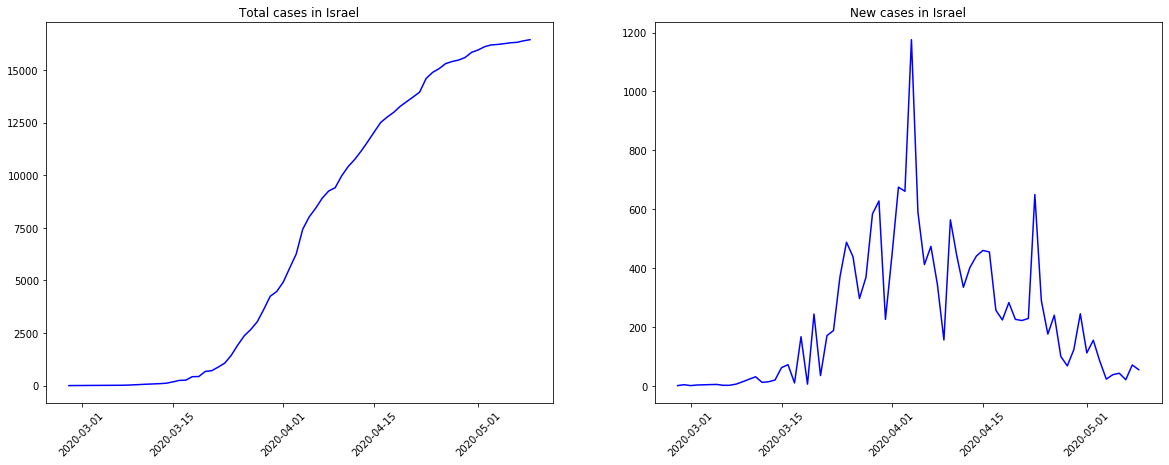

In [72]:
plot_country_data(israel)

In [73]:
def calculate_country_parameters(country_data,
                                 prior_mean=[-1, -1, -1],
                                 prior_sigma=[[10, 0, 0], [0, 10, 0], [0, 0, 10]]):
    country_log_dy = np.log(country_data.new_cases)
    country_train = np.arange(1, len(country_data) + 1)
    country_train = np.stack([country_train, country_train ** 2]).transpose()
    country_model = linear_model.LinearRegression(fit_intercept=True).fit(country_train, country_log_dy)
    country_log_dy_train_pred = log_dy_model.predict(country_train)
    _, country_noise_std = get_noise_params(country_log_dy_train_pred, country_log_dy)
    country_mu, country_sigma = np.array(prior_mean), 2*np.array(prior_sigma)

    i = len(x_train)
    for px, py in zip(country_train[:i], country_log_dy[:i]):
        country_mu, country_sigma = bayesian_update(country_mu, country_sigma, px, py, noise_std=country_noise_std)
    return {'mu': country_mu, 'sigma': country_sigma}

israel_params = calculate_country_parameters(israel)

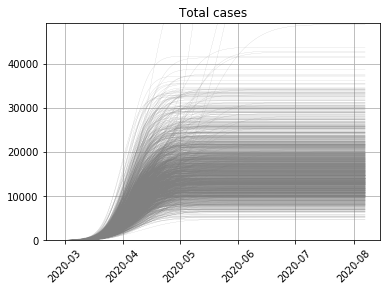

In [74]:
start = datetime.datetime(year=2020, month=2, day=28)
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(israel_params['mu'], israel_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=israel.total_cases.max()*3)

In [75]:
get_sigmoid_parameters(israel_params['mu'])

{'L': 14570.994968384392, 'mu': 39.37345627612006, 'sigma': 10.758148942628356}

#### Новая Зеландия

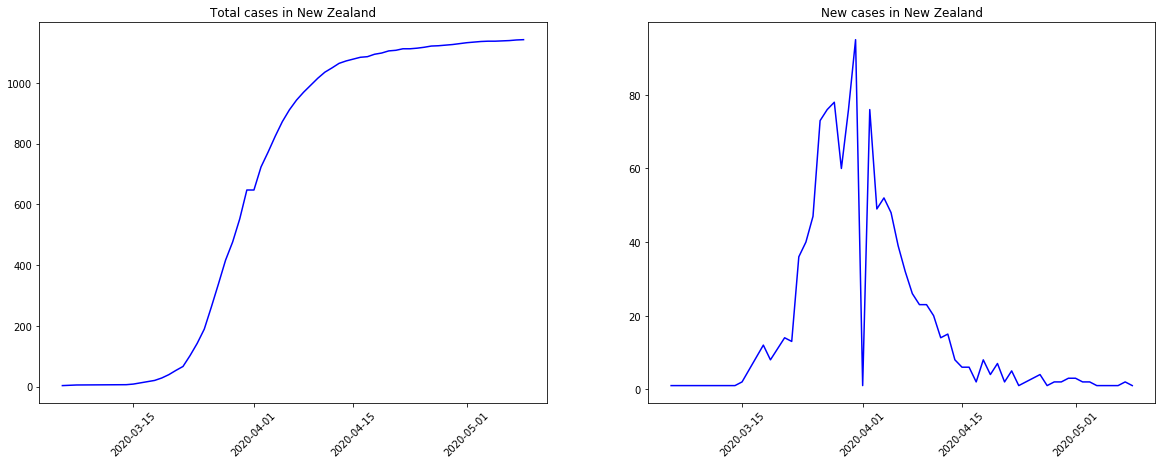

In [76]:
nz = get_country_data('New Zealand')
plot_country_data(nz)

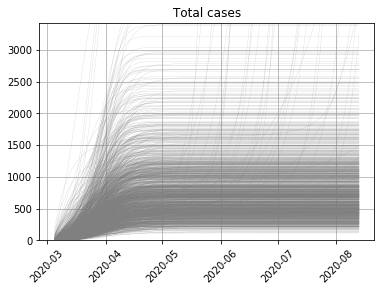

{'L': 642.3556814229577, 'mu': 24.25856758476987, 'sigma': 11.489798112894587}


In [77]:
nz_params = calculate_country_parameters(nz)
start = nz.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(nz_params['mu'], nz_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=nz.total_cases.max()*3)
print(get_sigmoid_parameters(nz_params['mu']))

#### США

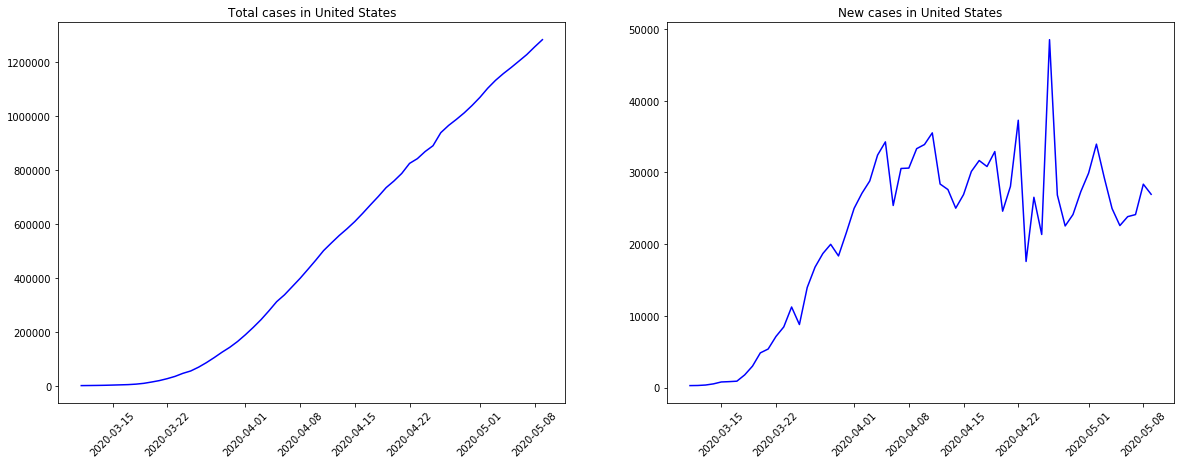

In [78]:
usa = get_country_data('United States')
usa = usa[usa.total_cases > 1000]
plot_country_data(usa)

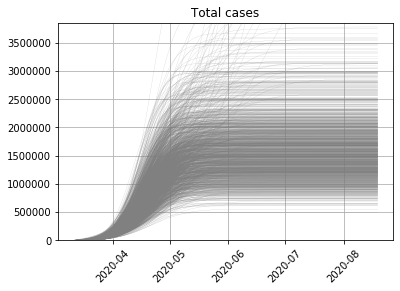

{'mu': array([ 5.61595241e+00,  2.58719728e-01, -3.26481104e-03]), 'sigma': array([[ 6.86389739e-01, -4.53737942e-02,  6.24968372e-04],
       [-4.53737942e-02,  3.96008572e-03, -6.11635040e-05],
       [ 6.24968372e-04, -6.11635040e-05,  1.00653936e-06]])}
{'L': 1434247.448691981, 'mu': 39.62246587941663, 'sigma': 12.37530687941613}


In [79]:
usa_params = calculate_country_parameters(usa)
start = usa.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(usa_params['mu'], usa_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=usa.total_cases.max()*3)
print(usa_params)
print(get_sigmoid_parameters(usa_params['mu']))

#### Италия

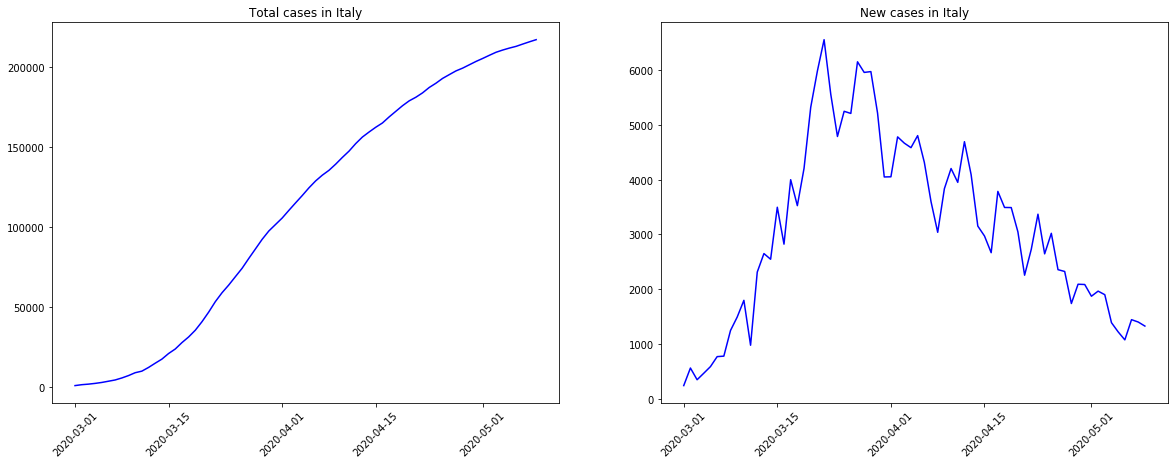

In [80]:
italy = get_country_data('Italy')
italy = italy[italy.total_cases > 1000]
plot_country_data(italy)

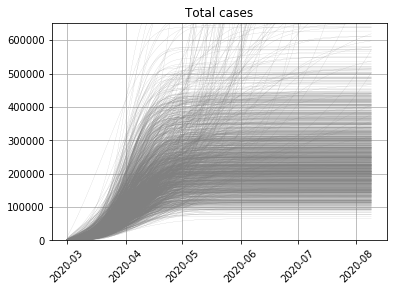

{'mu': array([ 5.48158836e+00,  1.83657417e-01, -2.61000137e-03]), 'sigma': array([[ 1.27631358e+00, -8.43669876e-02,  1.16202614e-03],
       [-8.43669876e-02,  7.41958675e-03, -1.14889228e-04],
       [ 1.16202614e-03, -1.14889228e-04,  1.89719456e-06]])}
{'L': 210870.87895747967, 'mu': 35.183394794550445, 'sigma': 13.840909675333014}


In [81]:
italy_params = calculate_country_parameters(italy)
start = italy.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(italy_params['mu'], italy_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=italy.total_cases.max()*3)
print(italy_params)
print(get_sigmoid_parameters(italy_params['mu']))

#### Испания

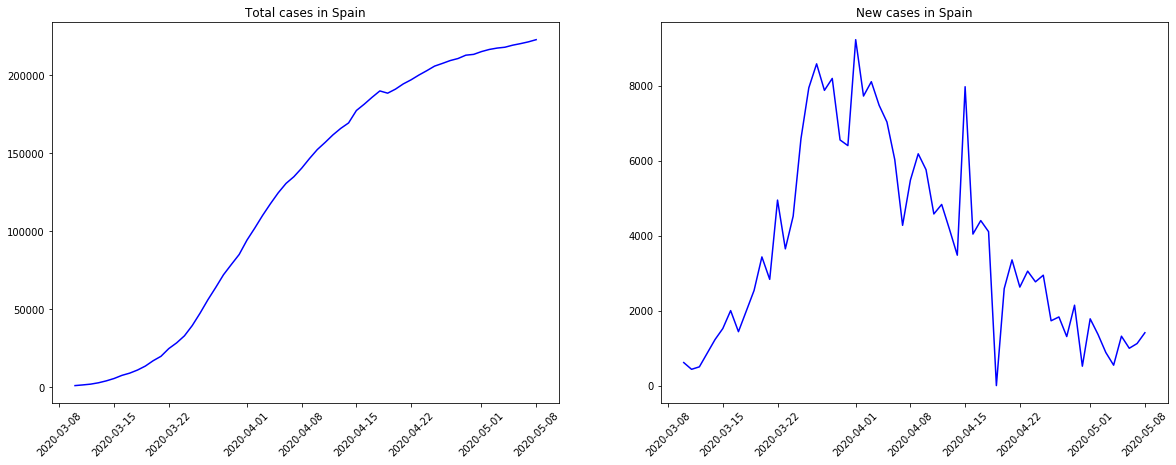

In [82]:
spain = get_country_data('Spain')
spain = spain[spain.total_cases > 1000]
spain.loc[spain.new_cases < 1, 'new_cases'] = 1
plot_country_data(spain)

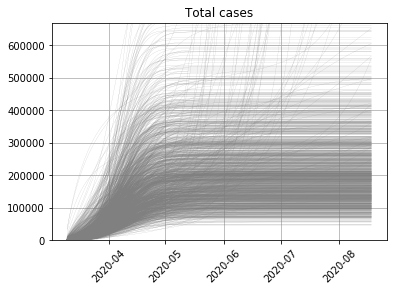

{'mu': array([ 6.04308351e+00,  1.74393116e-01, -2.93728030e-03]), 'sigma': array([[ 1.74002367e+00, -1.15014971e-01,  1.58412614e-03],
       [-1.15014971e-01,  1.01787218e-02, -1.57943794e-04],
       [ 1.58412614e-03, -1.57943794e-04,  2.61547804e-06]])}
{'L': 183343.10962702875, 'mu': 29.68615495906809, 'sigma': 13.047049369480526}


In [83]:
spain_params = calculate_country_parameters(spain)
start = spain.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(spain_params['mu'], spain_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=spain.total_cases.max()*3)
print(spain_params)
print(get_sigmoid_parameters(spain_params['mu']))

#### Франция

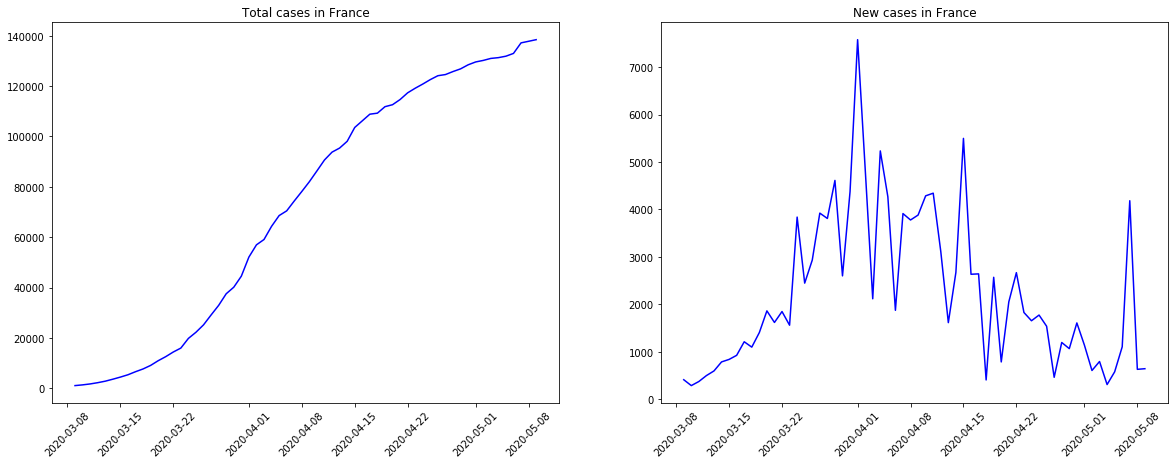

In [84]:
france = get_country_data('France')
france = france[france.total_cases > 1000]
france.loc[france.new_cases < 1, 'new_cases'] = 1
plot_country_data(france)

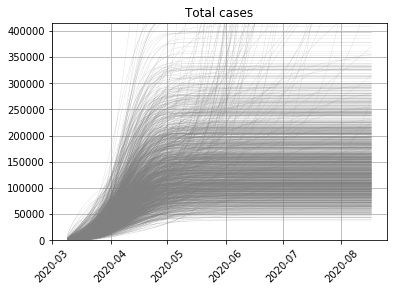

{'mu': array([ 5.43589761e+00,  1.74668647e-01, -2.74370967e-03]), 'sigma': array([[ 1.45053370e+00, -9.58820000e-02,  1.32061886e-03],
       [-9.58820000e-02,  8.45194169e-03, -1.30976710e-04],
       [ 1.32061886e-03, -1.30976710e-04,  2.16510565e-06]])}
{'L': 125166.65120774289, 'mu': 31.83074522401824, 'sigma': 13.499445354285164}


In [85]:
france_params = calculate_country_parameters(france)
start = france.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(france_params['mu'], france_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=france.total_cases.max()*3)
print(france_params)
print(get_sigmoid_parameters(france_params['mu']))

### Южная Корея

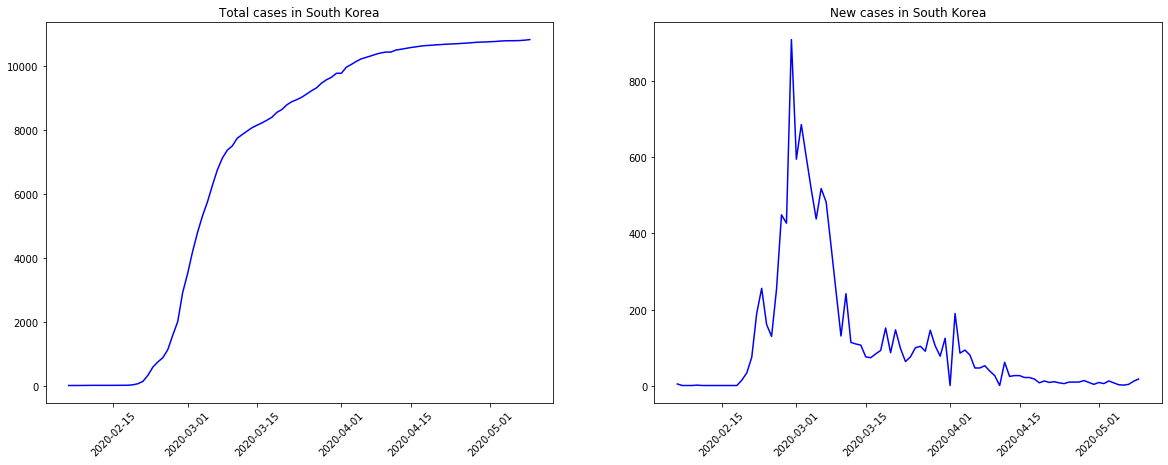

In [86]:
korea = get_country_data('South Korea')
korea = korea[korea.total_cases > 20]
korea.loc[korea.new_cases < 1, 'new_cases'] = 1
plot_country_data(korea)

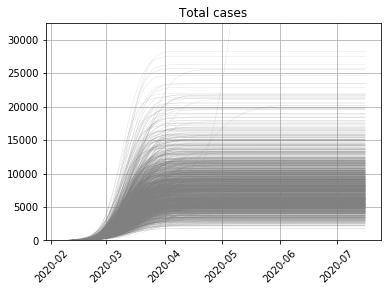

{'mu': array([-1.33075658,  0.37943348, -0.00514749]), 'sigma': array([[ 1.19017031e+00, -7.86732586e-02,  1.08360733e-03],
       [-7.86732586e-02,  6.91098447e-03, -1.06972968e-04],
       [ 1.08360733e-03, -1.06972968e-04,  1.76556945e-06]])}
{'L': 7104.380010816283, 'mu': 36.85618460403646, 'sigma': 9.855697503317765}


In [87]:
korea_params = calculate_country_parameters(korea)
start = korea.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(korea_params['mu'], korea_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=korea.total_cases.max()*3)
print(korea_params)
print(get_sigmoid_parameters(korea_params['mu']))

### United Kingdom

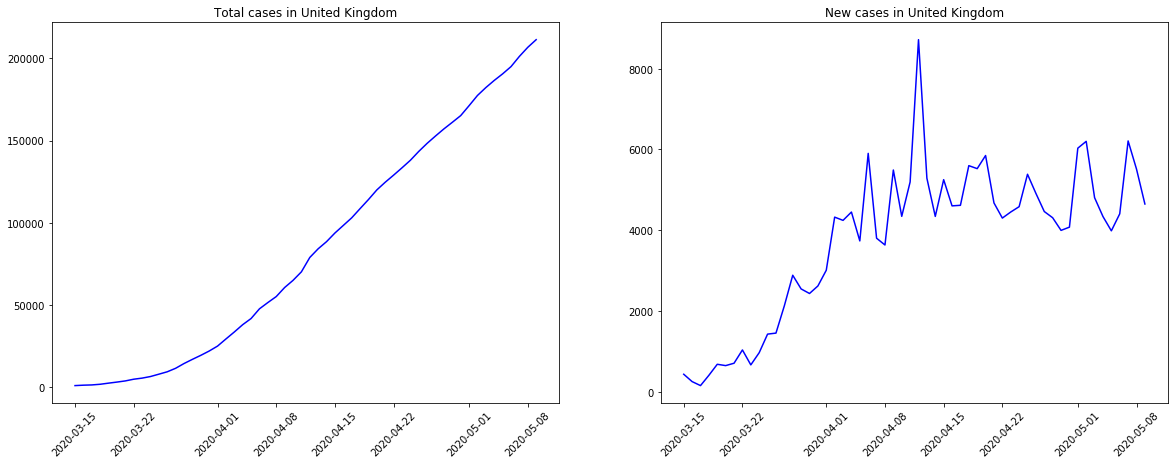

In [88]:
uk = get_country_data('United Kingdom')
uk = uk[uk.total_cases > 1000]
uk.loc[uk.new_cases < 1, 'new_cases'] = 1
plot_country_data(uk)

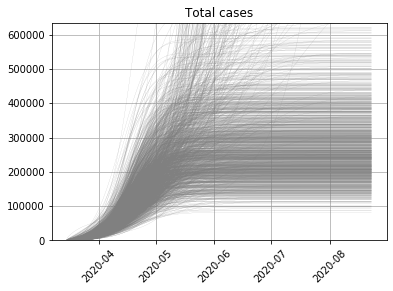

{'mu': array([ 5.29307017e+00,  1.84345031e-01, -2.42697078e-03]), 'sigma': array([[ 9.16160333e-01, -6.48476431e-02,  9.56419497e-04],
       [-6.48476431e-02,  6.07002694e-03, -1.00443657e-04],
       [ 9.56419497e-04, -1.00443657e-04,  1.77128807e-06]])}
{'L': 237175.89301736976, 'mu': 37.978419923053714, 'sigma': 14.353331920226642}


In [89]:
uk_params = calculate_country_parameters(uk)
start = uk.index.min()
dates = [start + datetime.timedelta(days=x) for x in range(162)]
x = np.arange(len(dates)) + 1
myplot_sample_bayesian_sigmoids(uk_params['mu'], uk_params['sigma'], x=x, n=1500,
                                title='Total cases', dates=dates, ylim=uk.total_cases.max()*3)
print(uk_params)
print(get_sigmoid_parameters(uk_params['mu']))

In [90]:
countries_mu = {
    'Israel': israel_params['mu'],
    'New Zealand': nz_params['mu'],
    'USA': usa_params['mu'],
    'Italy': italy_params['mu'],
    'Spain': spain_params['mu'],
    'France': france_params['mu'],
    'South Korea': korea_params['mu'],
    'United Kingdom': uk_params['mu']
}
countries_params = {country_name: get_sigmoid_parameters(countries_mu[country_name])
                        for country_name in countries_mu.keys()}

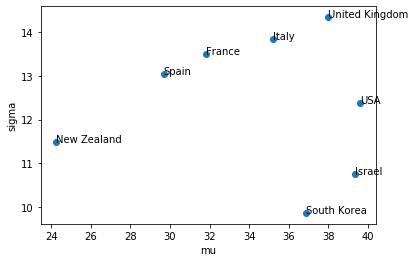

In [91]:
mu_s = [countries_params[country]['mu'] for country in countries_params]
sigma_s = [countries_params[country]['sigma'] for country in countries_params]
plt.scatter(mu_s, sigma_s)
plt.xlabel('mu')
plt.ylabel('sigma')
for country, mu, sigma in zip(countries_mu, mu_s, sigma_s):
    plt.annotate(country, (mu, sigma))

### <font color='blue'>Параметр L показывает общее количество случаев за всю эпидемию, поэтому его не будем отображать на графике, рассмотрим параметры mu и sigma - тут кажется что чем параметры больше - тем хуже страна смогла контролировать эпидемию. При этом Новая Зеландия, Южная Корея и Израиль справились лучше. Не очень понятно положения USA относительно UK, склоняюсь к тому, что эти параметры не настолько интерпретируемы, как можно было подумать сначала. </font>

### 5.
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

### <font color='blue'>С практической точки зрения - еще раз убедился в том, что нужно всегда выделять время на изучение данных и посмотреть что в их структуре может сильно повлиять на модель. В данной задаче, например, если отбрасывать начало периода заражения (для стран, в которых в дальнейшем десятки и сотни тысяч зараженных, лучше учитывать данные, начиная с 1000 зараженных) - это приводит к существенному уменьшению дисперсии.</font>

### <font color='blue'>На итоговое значение общего числа зараженных большое влияние оказывает форма кривой новых зараженных в день. Исходя из того, что всего людей конечное количество - понятно, что у этой кривой есть точка масимума, после которой она будет убывать. В данной модели мы моделируем логарифм этой величины параболой. Если удается сделать ее более пологой и с более низкой вершиной, то число заражений будет меньше, а также меньше будет нагрузка на систему здравоохранения.</font>

### <font color='blue'>Конкретно по данным моделям сложно что-то сказать об эффективности карантинных мер - то есть предсказать количественно насколько введение карантина повлияет на результат. С другой стороны понятно, что введение карантина уменьшает количество новых заражений в день, а следовательно если пользоваться нашей моделью - уменьшает общее число зараженных.</font>

### <font color='blue'>На примере России видно, как сильно на форму сигмоиды влияет включение в обучение середины-конца апреля, когда рост количества зараженных в день немного замедлился. Можно моделировать это уменьшение в зависимости от жесткости карантинных мер и потом строить сигмоиды по этим предсказаниям, чтобы посмотреть на итоговое влияние на общее число зараженных</font>